In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
warnings.filterwarnings('ignore')


In [9]:
data = pd.read_csv('../../Data/maize.csv')


In [10]:
target = data['price']
features = data.drop('price', axis=1)


In [11]:
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=100)


Tuning Models:   0%|          | 0/8 [00:00<?, ?it/s]

Tuning Model: Linear Regression:   0%|          | 0/1 [00:00<?, ?it/s]

Tuning Model: Random Forest:   0%|          | 0/1 [00:00<?, ?it/s]

Tuning Model: KNN Regressor:   0%|          | 0/1 [00:00<?, ?it/s]

Training Models:   0%|          | 0/8 [00:00<?, ?it/s]

Training Model: Linear Regression:   0%|          | 0/1 [00:00<?, ?it/s]

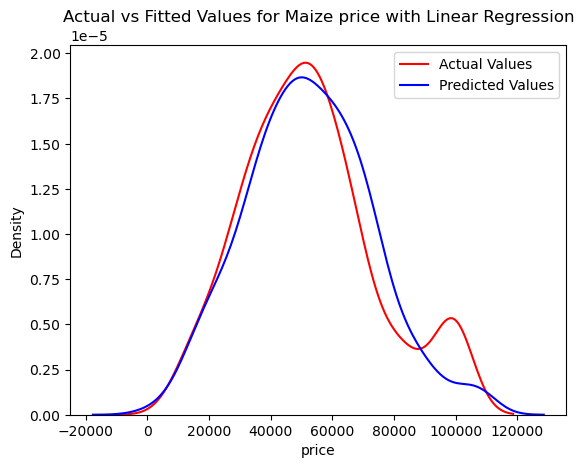

Training Model: Decision Tree:   0%|          | 0/1 [00:00<?, ?it/s]

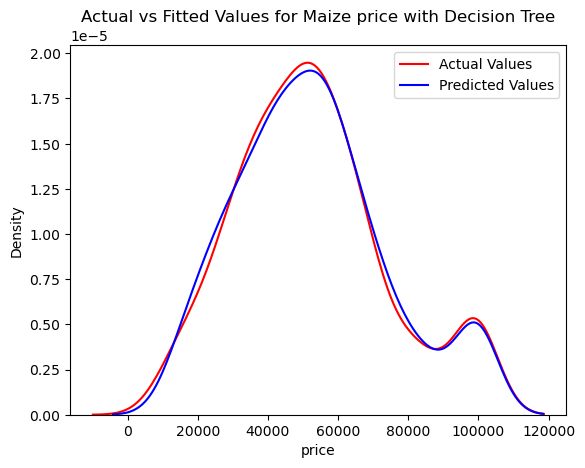

Training Model: Random Forest:   0%|          | 0/1 [00:00<?, ?it/s]

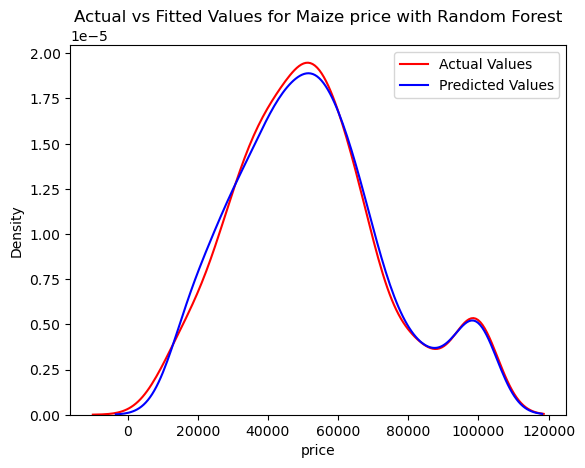

Training Model: KNN Regressor:   0%|          | 0/1 [00:00<?, ?it/s]

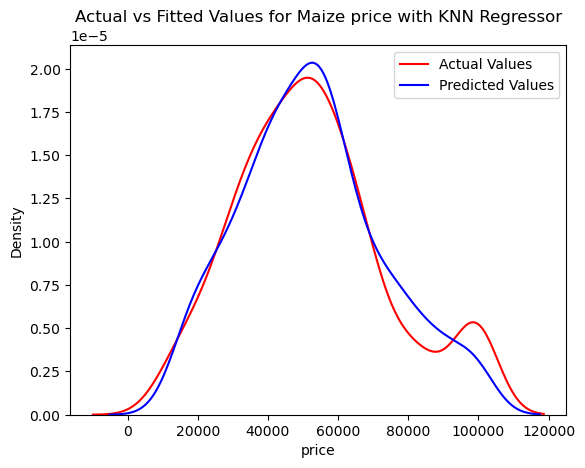

Training Model: Gradient Boosting:   0%|          | 0/1 [00:00<?, ?it/s]

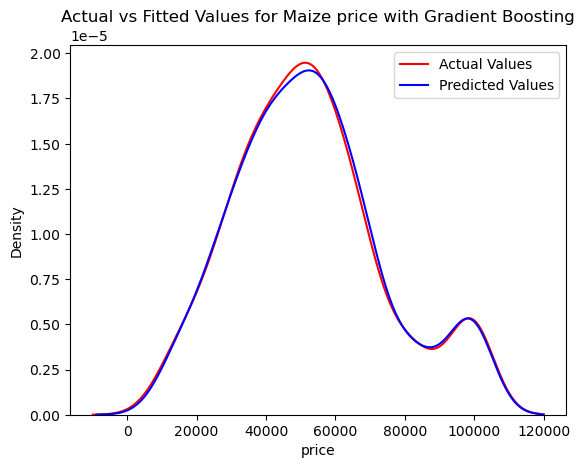

Training Model: XGBoost Regressor:   0%|          | 0/1 [00:00<?, ?it/s]

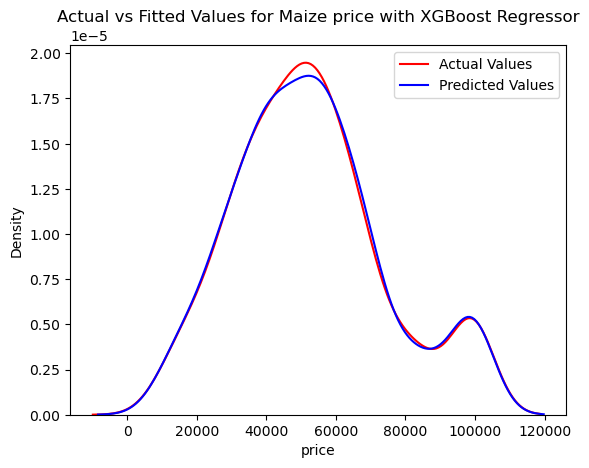

Training Model: LightGBM Regressor:   0%|          | 0/1 [00:00<?, ?it/s]

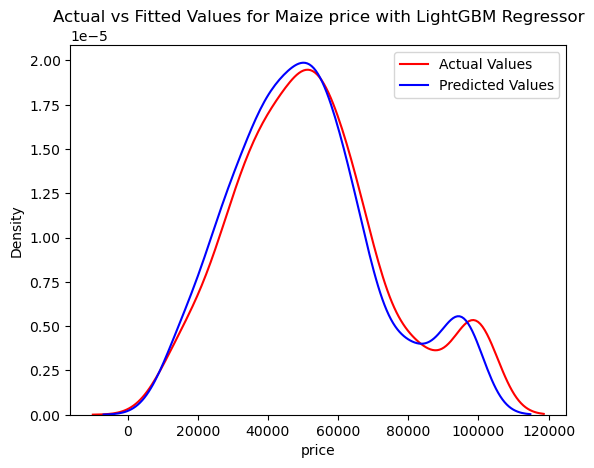

Training Model: CatBoost Regressor:   0%|          | 0/1 [00:00<?, ?it/s]

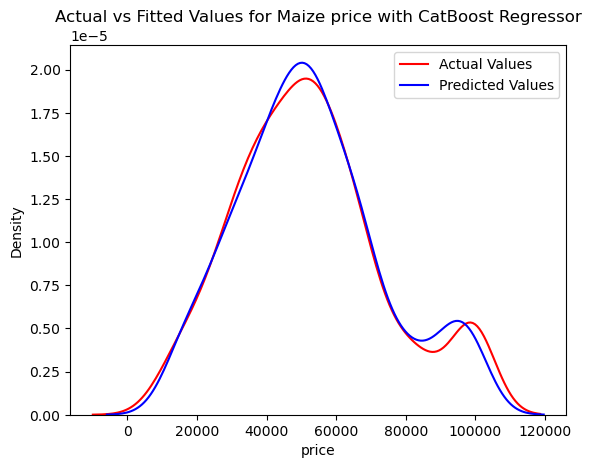

,Model Name,MAE,MSE,RMSE,R^2
0,Linear Regression,6926.600972,8.985616e+07,9479.248933,80.8038%
1,Decision Tree,2766.602267,1.876338e+07,4331.671452,95.9915%
2,Random Forest,2577.787429,1.758013e+07,4192.866300,96.2443%
3,KNN Regressor,6594.368111,8.697567e+07,9326.074703,81.4192%
4,Gradient Boosting,2505.609556,1.363683e+07,3692.808296,97.0867%
5,XGBoost Regressor,2265.164822,1.216448e+07,3487.761883,97.4013%
6,LightGBM Regressor,3058.912278,1.629697e+07,4036.950384,96.5184%
7,CatBoost Regressor,2879.267360,1.670878e+07,4087.637103,96.4305%


In [12]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=1000, random_state=42, min_samples_leaf=30, min_samples_split=50),
    'Random Forest': RandomForestRegressor(max_depth=1000, n_estimators=1000, random_state=42, min_samples_leaf=30, min_samples_split=50),
    'KNN Regressor': KNeighborsRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=1000,
        max_depth=1000,
        learning_rate=0.2,
        min_samples_leaf=30,
        min_samples_split=10
    ),
    'XGBoost Regressor': XGBRegressor(n_estimators=1000, max_depth=1000, learning_rate=0.2),
    'LightGBM Regressor': lgb.LGBMRegressor(
        objective='regression',
        metric='mse',
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        verbose=0,
        boosting_type='dart',
        learning_rate=0.2,
        n_estimators=100,
        num_leaves=30,
        max_depth=1000,
        verbosity=-1,
        silent=True
    ),
    'CatBoost Regressor': CatBoostRegressor(n_estimators=1000, max_depth=16, logging_level='Silent', learning_rate=0.2),
}

results = {
    'Model Name': [],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'R^2': []
}

param_grids = {
    'Linear Regression': {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'n_jobs': [10, 20, 60, 80, 100],
        'positive': [True, False]
    },
    'Random Forest': {
        'bootstrap': [True, False],
    },
    'KNN Regressor': {
        'n_neighbors': [1, 3, 5, 10, 20],
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
    }
}

best_models = {}

tuneBar = tqdm(models.items(), desc="Tuning Models")

for name, model in tuneBar:
    if name in param_grids:
        param_grid = param_grids[name]
        with tqdm(total=1, desc=f"Tuning Model: {name}") as insideBar:
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                                       scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
            grid_search.fit(feature_train, target_train)
            insideBar.update(1)
        best_model = grid_search.best_estimator_
        best_models[name] = best_model
    else:
        best_models[name] = model


trainBar = tqdm(models.items(), desc="Training Models")

for name, model in trainBar:
    with tqdm(total=1, desc=f"Training Model: {name}") as insideBar:
        model.fit(feature_train, target_train)
        pickle.dump(model, open(
            f'../../Models/Maize/Maize_model_{name}.pkl', 'wb'))
        model = pickle.load(
            open(f'../../Models/Maize/Maize_model_{name}.pkl', 'rb'))
        predictions = model.predict(feature_test)
        insideBar.update(1)

    mae = mean_absolute_error(target_test, predictions)
    mse = mean_squared_error(target_test, predictions)
    rmse = mean_squared_error(target_test, predictions, squared=False)
    r2 = r2_score(target_test, predictions)

    results['Model Name'].append(name)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R^2'].append(f'{r2 * 100:.4f}%')

    ax1 = sns.distplot(target_test, hist=False,
                       color="r", label="Actual Values")
    sns.distplot(predictions, hist=False, color="b",
                 label="Predicted Values", ax=ax1)
    plt.title(f'Actual vs Fitted Values for Maize price with {name}')
    plt.legend()
    plt.show()
    print()
    plt.close()

results = pd.DataFrame(results)
results
